## Imports and Initial Analysis

In [2]:
# Imports
import torch
import networkx as nx
import numpy as np
import joblib
import pickle
import os
import json 

from TemporalGraph import TemporalGraph, GraphWTime
from dataset_utils import load_or_generate_dataset, DEFAULT_FEATURE_METRICS
from evaluation_metrics import evaluate_model_on_test_data, evaluate_models_on_test_data, evaluate_edgebank_baseline, evaluate_model_in_live_update_setting, evaluate_edgebank_in_live_update_setting, compare_score_across_models
import matplotlib.pyplot as plt

In [3]:
NUM_ALL_NODES = 14814

# Load temporal graph (excluding test set a priori)
def load_steemit_graph(filename, all_nodes=list(range(NUM_ALL_NODES))):
    edges = torch.load(filename)
    edge_based_graph = nx.from_edgelist(np.array(edges).transpose())
    edge_based_graph.add_nodes_from(all_nodes)
    return edge_based_graph
    
graph_list = []
common_filename = "steemit-t3gnn-data/{time}_edge_index.pt"
max_time = 25
for time in range(max_time + 1):
    #print(f"Importing graph {time}/{max_time}")
    graph_list.append(GraphWTime(time, load_steemit_graph(common_filename.format(time=time))))

g = TemporalGraph(graph_list)

Novelty metrics: 0.3820394539732611


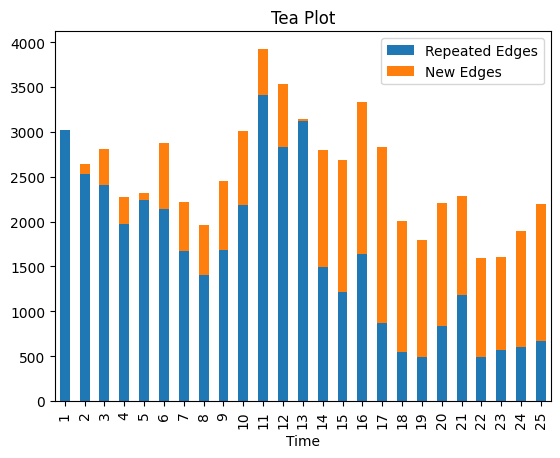

In [3]:
g.tea_plot(g.time_list()[1:])

In [4]:
g.reoccurence_and_surprise(g.time_list()[2:])

,Reoccurence Index,Surprise Index
2,0.032,0.971
3,0.045,0.954
4,0.055,0.938
5,0.052,0.934
6,0.054,0.925
7,0.065,0.901
8,0.052,0.909
9,0.053,0.900
10,0.050,0.897
11,0.042,0.905


In [5]:
# TODO visualize moving graph

Total (unique) nodes: 14814
Total (unique) edges: 75731


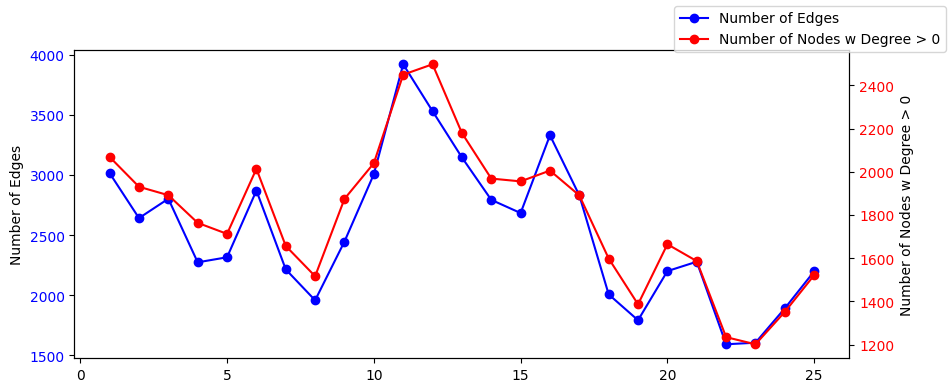

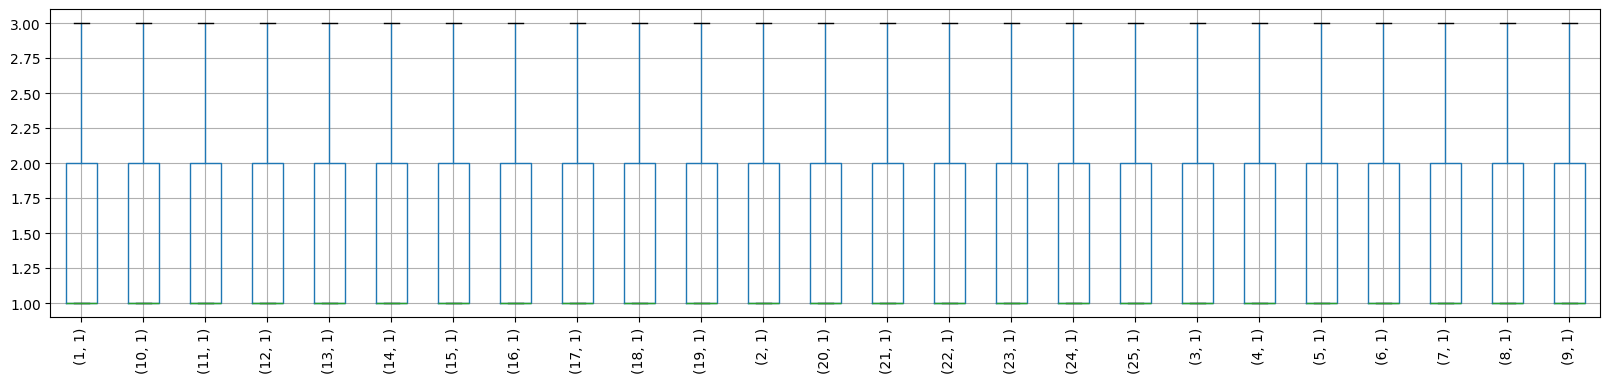

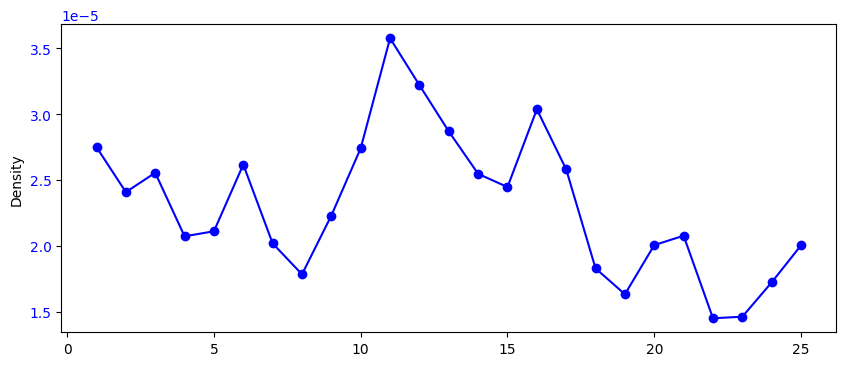

In [6]:
# Graph Analysis
# TODO other and prettier info
g.basic_analisys()

## Training example on fixed dataset and predictor family

In [20]:
# Generate Dataset

n_past_snapshot_to_consider=3
feature_metrics = DEFAULT_FEATURE_METRICS

edges, features, labels = load_or_generate_dataset(g, n_past_snapshot_to_consider, feature_metrics, negative_sampling="historical_negative")

In [8]:
# Separate train/test dataset based on snapshot time
TRAIN_TEST_SNAPSHOT_TIME = int(len(g.time_list())*.8)

train_features, train_labels = np.concatenate(features[:TRAIN_TEST_SNAPSHOT_TIME]), np.concatenate(labels[:TRAIN_TEST_SNAPSHOT_TIME])
test_features, test_labels = np.concatenate(features[TRAIN_TEST_SNAPSHOT_TIME:]), np.concatenate(labels[TRAIN_TEST_SNAPSHOT_TIME:])

In [9]:
# Define, fit and evaluate random model
# TODO better way to evaluate the model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300,max_depth=3)
model.fit(train_features, train_labels)
evaluate_model_on_test_data(model, test_features, test_labels)

{'accuracy_score': 0.844945594945595,
 'precision_score': 0.9039902774964553,
 'recall_score': 0.7753648366921473,
 'f1_score': 0.834751706724025,
 'roc_auc_score': 0.845661141750329,
 'average_precision_score': 0.8143831373431915}

In [10]:
evaluate_edgebank_baseline(edges[:TRAIN_TEST_SNAPSHOT_TIME], edges[TRAIN_TEST_SNAPSHOT_TIME:], labels[:TRAIN_TEST_SNAPSHOT_TIME], labels[TRAIN_TEST_SNAPSHOT_TIME:])

{'accuracy_score': 0.6484731484731485,
 'precision_score': 0.638318052481821,
 'recall_score': 0.7015288394718554,
 'f1_score': 0.6684323787452409,
 'roc_auc_score': 0.6479275403033037,
 'average_precision_score': 0.5985531733261575}

In [11]:
model_1_for_comparison = RandomForestClassifier(n_estimators=100,max_depth=2)
model_2_for_comparison = RandomForestClassifier(n_estimators=600,max_depth=6)

model_1_for_comparison.fit(train_features, train_labels)
model_2_for_comparison.fit(train_features, train_labels)

models = [("model_1_for_comparison", model_1_for_comparison), ("model_2_for_comparison", model_2_for_comparison)]
edgebank_baseline_data = {
        "train_edges": edges[:TRAIN_TEST_SNAPSHOT_TIME], 
        "test_edges": edges[TRAIN_TEST_SNAPSHOT_TIME:], 
        "train_labels": labels[:TRAIN_TEST_SNAPSHOT_TIME], 
        "test_labels": labels[TRAIN_TEST_SNAPSHOT_TIME:],
        "n_past_snapshots": 3
}
        
evaluate_models_on_test_data(models, test_features, test_labels, edgebank_baseline_data)

,model_1_for_comparison,model_2_for_comparison,edgebank_baseline_3_past_snapshots
accuracy_score,0.825377,0.849245,0.648473
precision_score,0.907223,0.898697,0.638318
recall_score,0.728805,0.790653,0.701529
f1_score,0.808285,0.841220,0.668432
roc_auc_score,0.826370,0.849848,0.647928
average_precision_score,0.798166,0.816296,0.598553


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": range(100, 1001, 100), "max_depth": range(1, 10, 2)}
scoring = {
        "accuracy_score": "accuracy",
        "precision_score": "precision",
        "recall_score": "recall",
        "f1_score": "f1",
        "roc_auc_score": "roc_auc",
        "average_precision_score": "average_precision"
    }

grid_search_random_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
grid_search_random_forest.fit(train_features, train_labels)
grid_search_random_forest.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=200)

In [13]:
evaluate_model_on_test_data(grid_search_random_forest, test_features, test_labels)

{'accuracy_score': 0.84994734994735,
 'precision_score': 0.9013888888888889,
 'recall_score': 0.7892633773453788,
 'f1_score': 0.8416080029640608,
 'roc_auc_score': 0.8505714049847461,
 'average_precision_score': 0.8178740951868992}

## Training example on fixed dataset varying predictor family

In [6]:
# Generate Dataset

n_past_snapshot_to_consider=3
feature_metrics = DEFAULT_FEATURE_METRICS

edges, features, labels = load_or_generate_dataset(g, n_past_snapshot_to_consider, feature_metrics, negative_sampling="historical_negative")

In [7]:
# Separate train/test dataset based on snapshot time
TRAIN_TEST_SNAPSHOT_TIME = int(len(g.time_list())*.8)

train_features, train_labels = np.concatenate(features[:TRAIN_TEST_SNAPSHOT_TIME]), np.concatenate(labels[:TRAIN_TEST_SNAPSHOT_TIME])
test_features, test_labels = np.concatenate(features[TRAIN_TEST_SNAPSHOT_TIME:]), np.concatenate(labels[TRAIN_TEST_SNAPSHOT_TIME:])

In [22]:
from sklearn.model_selection import GridSearchCV

scoring = {
        "accuracy_score": "accuracy",
        "precision_score": "precision",
        "recall_score": "recall",
        "f1_score": "f1",
        "roc_auc_score": "roc_auc",
        "average_precision_score": "average_precision"
    }

In [23]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbors_param_grid = {
    "n_neighbors": range(1, 20, 3),
    "weights": ["uniform", "distance"]
}

nearest_neighbors_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=nearest_neighbors_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
nearest_neighbors_grid_search.fit(train_features, train_labels)
joblib.dump(nearest_neighbors_grid_search, 'grid_search_results/nearest_neighbors_grid_search.pkl')

['grid_search_results/nearest_neighbors_grid_search.pkl']

In [24]:
from sklearn.svm import LinearSVC

svc_param_grid = {
    'C':[10,100,1000],
    'penalty':['l1', 'l2'],
}

svc_grid_search = GridSearchCV(LinearSVC(dual="auto"), param_grid=svc_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
svc_grid_search.fit(train_features, train_labels)
joblib.dump(svc_grid_search, 'grid_search_results/svc_grid_search.pkl')

['grid_search_results/svc_grid_search.pkl']

In [25]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(5, 50, 5),
}

decision_tree_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=decision_tree_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
decision_tree_grid_search.fit(train_features, train_labels)
joblib.dump(decision_tree_grid_search, 'grid_search_results/decision_tree_grid_search.pkl')

['grid_search_results/decision_tree_grid_search.pkl']

In [26]:
from sklearn.ensemble import RandomForestClassifier

random_forest_param_grid = {
    "n_estimators": range(100, 1001, 100), 
    "max_depth": range(1, 10, 2)
}


random_forest_grid_search = GridSearchCV(RandomForestClassifier(), param_grid=random_forest_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
random_forest_grid_search.fit(train_features, train_labels)
joblib.dump(random_forest_grid_search, 'grid_search_results/random_forest_grid_search.pkl')

/Users/matteo.biglioli/Documents/personal/thesis/transaction_prediction_finet/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['grid_search_results/random_forest_grid_search.pkl']

In [27]:
from sklearn.neural_network import MLPClassifier

mlp_param_grid = {
    'hidden_layer_sizes': [(50,),(100,),(150,)],  # Tuple representing the size of hidden layers
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],  # 'adam' is a popular solver for large datasets
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 400],
    'early_stopping': [True],  # Enable early stopping to prevent overfitting
    'validation_fraction': [0.1],  # Fraction of training data to set aside as validation set for early stopping
}

mlp_grid_search = GridSearchCV(MLPClassifier(), param_grid=mlp_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
mlp_grid_search.fit(train_features, train_labels)
joblib.dump(mlp_grid_search, 'grid_search_results/mlp_grid_search.pkl')

/Users/matteo.biglioli/Documents/personal/thesis/transaction_prediction_finet/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['grid_search_results/mlp_grid_search.pkl']

In [28]:
from catboost import CatBoostClassifier

catboost_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [3, 7],
}

catboost_grid_search = GridSearchCV(CatBoostClassifier(silent=True), param_grid=catboost_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
catboost_grid_search.fit(train_features, train_labels)
joblib.dump(catboost_grid_search, 'grid_search_results/catboost_grid_search.pkl')

/Users/matteo.biglioli/Documents/personal/thesis/transaction_prediction_finet/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['grid_search_results/catboost_grid_search.pkl']

In [29]:
import lightgbm as lgb

lightgbm_param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
}

lightgbm_grid_search = GridSearchCV(lgb.LGBMClassifier(verbose=-1), param_grid=lightgbm_param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
lightgbm_grid_search.fit(train_features, train_labels)
joblib.dump(lightgbm_grid_search, 'grid_search_results/lightgbm_grid_search.pkl')

['grid_search_results/lightgbm_grid_search.pkl']

In [30]:
models = [("nearest_neighbors", nearest_neighbors_grid_search), 
          ("svc", svc_grid_search), 
          ("decision_tree", decision_tree_grid_search), 
          ("random_forest", random_forest_grid_search), 
          ("mlp", mlp_grid_search), 
          ("catboost", catboost_grid_search), 
          ("lightgbm", lightgbm_grid_search)]

edgebank_baseline_data = {
        "train_edges": edges[:TRAIN_TEST_SNAPSHOT_TIME], 
        "test_edges": edges[TRAIN_TEST_SNAPSHOT_TIME:], 
        "train_labels": labels[:TRAIN_TEST_SNAPSHOT_TIME], 
        "test_labels": labels[TRAIN_TEST_SNAPSHOT_TIME:],
        "n_past_snapshots": 3
}

evaluate_models_on_test_data(models, test_features, test_labels, edgebank_baseline_data)

,nearest_neighbors,svc,decision_tree,random_forest,mlp,catboost,lightgbm,edgebank_baseline_3_past_snapshots
accuracy_score,0.827483,0.663127,0.844682,0.850123,0.847754,0.847490,0.847403,0.648473
precision_score,0.909287,0.917283,0.907566,0.902386,0.908223,0.907836,0.903394,0.638318
recall_score,0.731411,0.366053,0.771022,0.788568,0.777102,0.776928,0.781445,0.701529
f1_score,0.810707,0.523283,0.833740,0.841647,0.837562,0.837296,0.838007,0.668432
roc_auc_score,0.828471,0.666182,0.845440,0.850756,0.848480,0.848216,0.848081,0.647928
average_precision_score,0.800724,0.655974,0.815408,0.818385,0.818366,0.817995,0.816343,0.598553


## Training example varying dataset and predictor family

In [12]:
# Common values
feature_metrics = DEFAULT_FEATURE_METRICS
TRAIN_TEST_SNAPSHOT_TIME = int(len(g.time_list())*.8)

scoring = {
        "accuracy_score": "accuracy",
        "precision_score": "precision",
        "recall_score": "recall",
        "f1_score": "f1",
        "roc_auc_score": "roc_auc",
        "average_precision_score": "average_precision"
    }

In [10]:
# Common models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

nearest_neighbors_param_grid = {
    "n_neighbors": range(1, 20, 3),
    "weights": ["uniform", "distance"]
}

random_forest_param_grid = {
    "n_estimators": range(100, 1001, 100), 
    "max_depth": range(1, 10, 2)
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,),(100,),(150,)],  # Tuple representing the size of hidden layers
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],  # 'adam' is a popular solver for large datasets
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 400],
    'validation_fraction': [0.1],  # Fraction of training data to set aside as validation set for early stopping
}

catboost_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [3, 7],
}

lightgbm_param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
}


models = [("nearest_neighbors" , KNeighborsClassifier(), nearest_neighbors_param_grid),
        ("random_forest" , RandomForestClassifier(), random_forest_param_grid),
        ("mlp" , MLPClassifier(), mlp_param_grid),
        ("catboost" , CatBoostClassifier(silent=True), catboost_param_grid),
        ("lightgbm" , lgb.LGBMClassifier(verbose=-1), lightgbm_param_grid)] 

In [7]:
# Train and Save models
for n_past_snapshot_to_consider in range(1, 6):
    print(f"Working on n_past_snapshot_to_consider: {n_past_snapshot_to_consider}")

    # Generate (or load) Dataset 
    edges, features, labels = load_or_generate_dataset(g, n_past_snapshot_to_consider, feature_metrics, negative_sampling="historical_negative")

    # Train-Test split
    train_features, train_labels = np.concatenate(features[:TRAIN_TEST_SNAPSHOT_TIME]), np.concatenate(labels[:TRAIN_TEST_SNAPSHOT_TIME])

    # Train models
    grid_search_results_common_path = f'grid_search_results/{n_past_snapshot_to_consider}_past_snapshot'

    for model_name, model, param_grid in models:
        grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scoring, refit="average_precision_score", n_jobs=-1, cv=3)
        grid_search.fit(train_features, train_labels)
        joblib.dump(grid_search, f'{grid_search_results_common_path}/{model_name}_grid_search.pkl')

Working on n_past_snapshot_to_consider: 1
Working on n_past_snapshot_to_consider: 2
Working on n_past_snapshot_to_consider: 3
Working on n_past_snapshot_to_consider: 4
Working on n_past_snapshot_to_consider: 5


KeyboardInterrupt: 

In [13]:
evaluation_df_list = []
feature_metrics = DEFAULT_FEATURE_METRICS


for n_past_snapshot_to_consider in range(1, 6):
        print(f"Working on n_past_snapshot_to_consider: {n_past_snapshot_to_consider}")

        # Load models
        grid_search_results_common_path = f'grid_search_results/{n_past_snapshot_to_consider}_past_snapshot'
        models = [(f"nearest_neighbors_{n_past_snapshot_to_consider}_past_snapshot", joblib.load(f"{grid_search_results_common_path}/nearest_neighbors_grid_search.pkl")), 
                (f"random_forest_{n_past_snapshot_to_consider}_past_snapshot", joblib.load(f"{grid_search_results_common_path}/random_forest_grid_search.pkl")), 
                (f"mlp_{n_past_snapshot_to_consider}_past_snapshot", joblib.load(f"{grid_search_results_common_path}/mlp_grid_search.pkl")),
                (f"catboost_{n_past_snapshot_to_consider}_past_snapshot", joblib.load(f"{grid_search_results_common_path}/catboost_grid_search.pkl")),
                (f"lightgbm_{n_past_snapshot_to_consider}_past_snapshot", joblib.load(f"{grid_search_results_common_path}/lightgbm_grid_search.pkl"))]

        # Load or Generate dataset
        edges, features, labels = load_or_generate_dataset(g, n_past_snapshot_to_consider, feature_metrics, negative_sampling="historical_negative")
        test_features, test_labels = np.concatenate(features[TRAIN_TEST_SNAPSHOT_TIME:]), np.concatenate(labels[TRAIN_TEST_SNAPSHOT_TIME:])

        edgebank_baseline_data_1_past_snapshot = {
                "train_edges": edges[:TRAIN_TEST_SNAPSHOT_TIME], "test_edges": edges[TRAIN_TEST_SNAPSHOT_TIME:], 
                "train_labels": labels[:TRAIN_TEST_SNAPSHOT_TIME], "test_labels": labels[TRAIN_TEST_SNAPSHOT_TIME:], 
                "n_past_snapshots": n_past_snapshot_to_consider
        }

        # Evaluate models
        evaluation_df_list.append(evaluate_models_on_test_data(models, test_features, test_labels, edgebank_baseline_data_1_past_snapshot))

evaluation_df_1_past_snapshot, evaluation_df_2_past_snapshot, evaluation_df_3_past_snapshot, evaluation_df_4_past_snapshot, evaluation_df_5_past_snapshot = evaluation_df_list

Working on n_past_snapshot_to_consider: 1
Working on n_past_snapshot_to_consider: 2
Working on n_past_snapshot_to_consider: 3
Working on n_past_snapshot_to_consider: 4
Working on n_past_snapshot_to_consider: 5


In [34]:
print(evaluation_df_1_past_snapshot.to_latex()\
      .replace("accuracy_score", "Accuracy")\
        .replace("precision_score", "Precision")\
            .replace("recall_score", "Recall")\
                .replace("f1_score", "F1")\
                    .replace("roc_auc_score", "ROC AUC")\
                        .replace("average_Precision", "Average Precision"))

\begin{tabular}{lrrrrrr}
\toprule
 & nearest_neighbors_1_past_snapshot & random_forest_1_past_snapshot & mlp_1_past_snapshot & catboost_1_past_snapshot & lightgbm_1_past_snapshot & edgebank_baseline_1_past_snapshots \\
\midrule
Accuracy & 0.456222 & 0.824731 & 0.824626 & 0.824731 & 0.824731 & 0.597795 \\
Precision & 0.479257 & 0.913585 & 0.913562 & 0.913585 & 0.913585 & 0.591502 \\
Recall & 0.891856 & 0.720998 & 0.720791 & 0.720998 & 0.720998 & 0.656939 \\
F1 & 0.623476 & 0.805946 & 0.805808 & 0.805946 & 0.805946 & 0.622506 \\
ROC AUC & 0.451994 & 0.825738 & 0.825634 & 0.825738 & 0.825738 & 0.597221 \\
Average Precision & 0.482020 & 0.799535 & 0.799434 & 0.799535 & 0.799535 & 0.561760 \\
\bottomrule
\end{tabular}



In [23]:
evaluation_df_2_past_snapshot

,nearest_neighbors_2_past_snapshot,random_forest_2_past_snapshot,mlp_2_past_snapshot,catboost_2_past_snapshot,lightgbm_2_past_snapshot,edgebank_baseline_2_past_snapshots
accuracy_score,0.809491,0.829173,0.843986,0.827596,0.834042,0.637430
precision_score,0.905714,0.907253,0.910881,0.910754,0.907667,0.625241
recall_score,0.695180,0.737135,0.766056,0.730210,0.747454,0.704277
f1_score,0.786603,0.813394,0.832215,0.810550,0.819806,0.662410
roc_auc_score,0.810663,0.830117,0.844785,0.828594,0.834930,0.636744
average_precision_score,0.783591,0.801534,0.815945,0.801306,0.805994,0.589705


In [21]:
import pandas as pd

evaluation_metrics = [evaluation_df_1_past_snapshot, evaluation_df_2_past_snapshot, evaluation_df_3_past_snapshot, evaluation_df_4_past_snapshot, evaluation_df_5_past_snapshot]
pd.concat(evaluation_metrics, axis=1)

,nearest_neighbors_1_past_snapshot,random_forest_1_past_snapshot,mlp_1_past_snapshot,catboost_1_past_snapshot,lightgbm_1_past_snapshot,edgebank_baseline_1_past_snapshots,nearest_neighbors_2_past_snapshot,random_forest_2_past_snapshot,mlp_2_past_snapshot,catboost_2_past_snapshot,...,mlp_4_past_snapshot,catboost_4_past_snapshot,lightgbm_4_past_snapshot,edgebank_baseline_4_past_snapshots,nearest_neighbors_5_past_snapshot,random_forest_5_past_snapshot,mlp_5_past_snapshot,catboost_5_past_snapshot,lightgbm_5_past_snapshot,edgebank_baseline_5_past_snapshots
accuracy_score,0.456222,0.824731,0.824626,0.824731,0.824731,0.597795,0.809491,0.829173,0.843986,0.827596,...,0.839932,0.838343,0.840909,0.675587,0.826818,0.844318,0.834545,0.840000,0.848182,0.682727
precision_score,0.479257,0.913585,0.913562,0.913585,0.913585,0.591502,0.905714,0.907253,0.910881,0.910754,...,0.907338,0.905118,0.901556,0.666741,0.893514,0.890076,0.894180,0.895094,0.893002,0.672255
recall_score,0.891856,0.720998,0.720791,0.720998,0.720998,0.656939,0.695180,0.737135,0.766056,0.730210,...,0.761410,0.760203,0.769621,0.717460,0.745266,0.788548,0.761948,0.773219,0.793959,0.723174
f1_score,0.623476,0.805946,0.805808,0.805946,0.805946,0.622506,0.786603,0.813394,0.832215,0.810550,...,0.827994,0.826355,0.830380,0.691171,0.812684,0.836242,0.822785,0.829705,0.840573,0.696785
roc_auc_score,0.451994,0.825738,0.825634,0.825738,0.825738,0.597221,0.810663,0.830117,0.844785,0.828594,...,0.840883,0.839290,0.841773,0.675079,0.827491,0.844778,0.835144,0.840551,0.848629,0.682394
average_precision_score,0.482020,0.799535,0.799434,0.799535,0.799535,0.561760,0.783591,0.801534,0.815945,0.801306,...,0.811580,0.809408,0.810425,0.621322,0.794314,0.808459,0.801318,0.806422,0.812870,0.625703


# T3GNN live update grid search

In [3]:
from t3gnn import T3GNN

def custom_grid_search_t3gnn(n_past_snapshot_to_consider, t3gnn_param_grid):
    import itertools
    import json

    storage_path = f'grid_search_results/{n_past_snapshot_to_consider}_past_snapshot'

    feature_metrics = DEFAULT_FEATURE_METRICS
    _, features, labels = load_or_generate_dataset(g, n_past_snapshot_to_consider, feature_metrics, negative_sampling="historical_negative")
    
    keys = ['num_gnn_layers', 'update', 'hidden_dim']
    for values in itertools.product(*map(t3gnn_param_grid.get, keys)):
        num_gnn_layers, update, hidden_dim = values
        print("testing w -> num_gnn_layers: ", num_gnn_layers, "update: ", update, "hidden_dim: ", hidden_dim)
        if os.path.exists(f"{storage_path}/tmp/num_gnn_layers_{num_gnn_layers}_update_{update}_hidden_dim_{hidden_dim}.json"):
            continue

        model = T3GNN(input_dim=1, num_gnn_layers=num_gnn_layers, hidden_dim=hidden_dim, dropout=0.3, update=update)
        if update in ['gru','mlp']: model.reset_parameters()
        model_metrics_df = evaluate_model_in_live_update_setting(g, model, features, labels, n_past_snapshot_to_consider, max_time)
        mean_average_precision_score = np.mean(model_metrics_df["average_precision_score"])
        params_w_mean_average_precision_score = {
                'mean_average_precision_score': mean_average_precision_score,
                'num_gnn_layers': num_gnn_layers,
                'update': update,
                'hidden_dim': hidden_dim,
            }
        json.dump(params_w_mean_average_precision_score, open(f"{storage_path}/tmp/num_gnn_layers_{num_gnn_layers}_update_{update}_hidden_dim_{hidden_dim}.json", "w"))

In [ ]:
t3gnn_param_grid = {
    'num_gnn_layers': [1,2,3],
    'update': ['gru','mlp','linrnn','avg'],
    'hidden_dim': [32, 64, 128, 256, 512],
}

custom_grid_search_t3gnn(1, t3gnn_param_grid)

# Live Update Setting

In [47]:
## Find best configuration for live update setting
def find_best_t3gnn_config():
    storage_path = "grid_search_results/1_past_snapshot/tmp/"

    best_mean_average_precision_score = 0
    best_params = {}
    for config_file in os.listdir(storage_path):
        if config_file.endswith('.json'):
            config = json.load(open(f"{storage_path}/{config_file}", "r"))
            if config["mean_average_precision_score"] > best_mean_average_precision_score:
                best_mean_average_precision_score = config["mean_average_precision_score"]
                best_params = config

    return config

In [48]:
find_best_t3gnn_config()

{'mean_average_precision_score': 0.6651640243105988,
 'num_gnn_layers': 1,
 'update': 'mlp',
 'hidden_dim': 256}

In [12]:
# Generate and save metrics csv
from t3gnn import T3GNN

feature_metrics = DEFAULT_FEATURE_METRICS
model_names = ["nearest_neighbors", "mlp", "catboost", "lightgbm"]

for n_past_snapshot_to_consider in range(1, 6):
    print(f"Working on n_past_snapshot_to_consider: {n_past_snapshot_to_consider}")

    edges, features, labels = load_or_generate_dataset(g, n_past_snapshot_to_consider, feature_metrics, negative_sampling="historical_negative")

    metrics_common_path = f"live_update_metrics/{n_past_snapshot_to_consider}_past_snapshot"
    if not os.path.exists(metrics_common_path):
        os.makedirs(metrics_common_path)

    for model_name in model_names:
        model = joblib.load(f'grid_search_results/{n_past_snapshot_to_consider}_past_snapshot/{model_name}_grid_search.pkl').best_estimator_
        model_metrics_df = evaluate_model_in_live_update_setting(g, model, features, labels, n_past_snapshot_to_consider, max_time)
        model_metrics_df.to_csv(f"{metrics_common_path}/{model_name}_metrics_df.csv")


    edgebank_df = evaluate_edgebank_in_live_update_setting(edges, labels, n_past_snapshot_to_consider, max_time)
    edgebank_df.to_csv(f"{metrics_common_path}/edgebank_metrics_df.csv")

    # T3GNN
    model_params = find_best_t3gnn_config()
    t3gnn_edges, t3gnn_features, t3gnn_labels = load_or_generate_dataset(g, 1, feature_metrics, negative_sampling="historical_negative")
    model = T3GNN(input_dim=1, num_gnn_layers=model_params['num_gnn_layers'], hidden_dim=model_params['hidden_dim'], dropout=0.3, update=model_params['update'])
    t3gnn_metrics_df = evaluate_model_in_live_update_setting(g, model, t3gnn_features, t3gnn_labels, 1, max_time)
    t3gnn_metrics_df.drop(t3gnn_metrics_df[t3gnn_metrics_df.index < n_past_snapshot_to_consider + 1].index).to_csv(f"{metrics_common_path}/t3gnn_metrics_df.csv")


Working on n_past_snapshot_to_consider: 1
Working on n_past_snapshot_to_consider: 2
Working on n_past_snapshot_to_consider: 3
Working on n_past_snapshot_to_consider: 4
Working on n_past_snapshot_to_consider: 5


In [4]:
def compare_score_across_models(score_list, metric_chosen = "average_precision_score"):
    # Assume that score list is a list of scores_df like
    # [(model_name_a, scores_df_a), (model_name_b, scores_df_b), ...]

    metrics_df = pd.DataFrame()
    metrics_df.index = score_list[0][1].index

    for model_name, score_df in score_list:
        metrics_df[f"{model_name} - {metric_chosen}"] = score_df[metric_chosen]
    metrics_df.plot(figsize=(15, 5), grid=True, xticks=metrics_df.index)

N past snapshot considered:  1


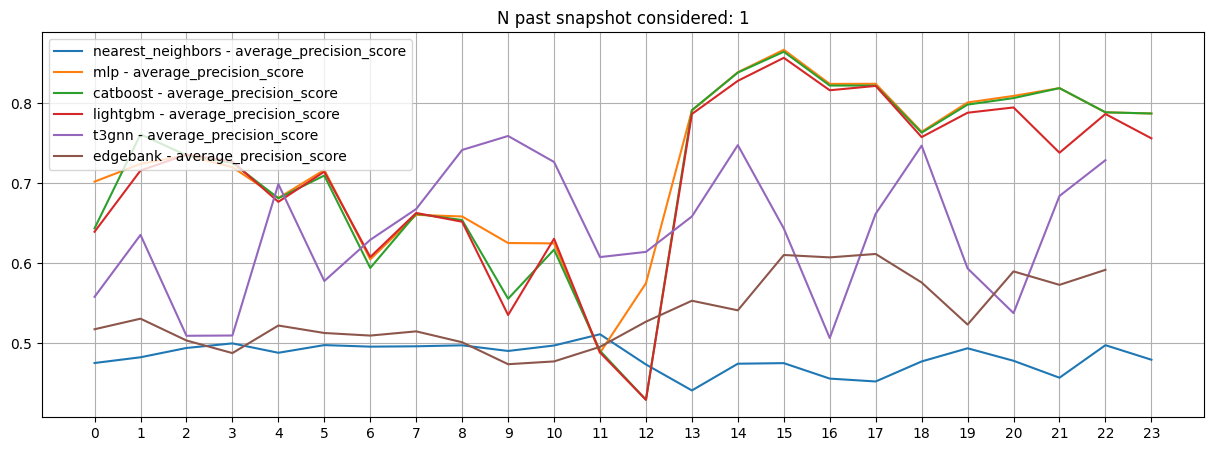

N past snapshot considered:  2


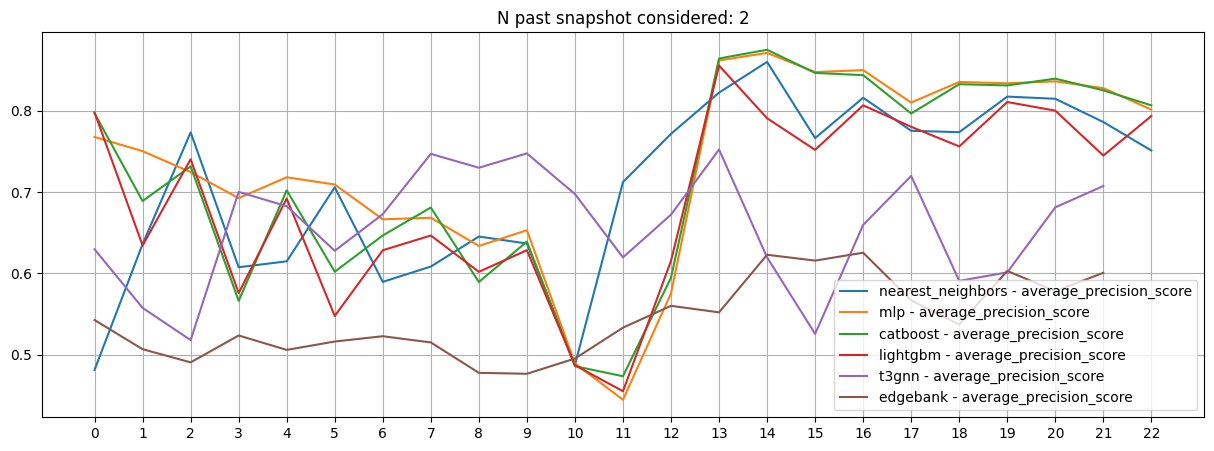

N past snapshot considered:  3


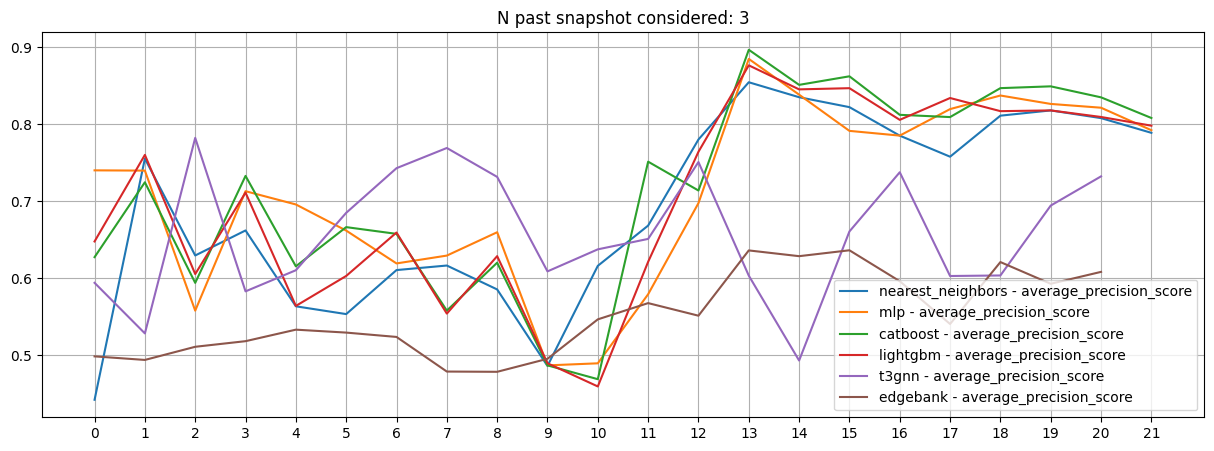

N past snapshot considered:  4


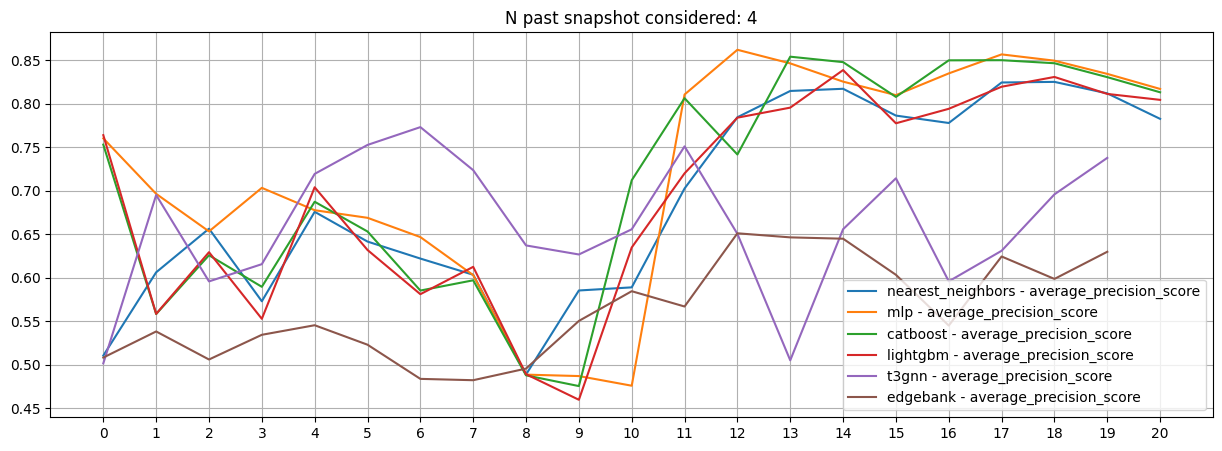

N past snapshot considered:  5


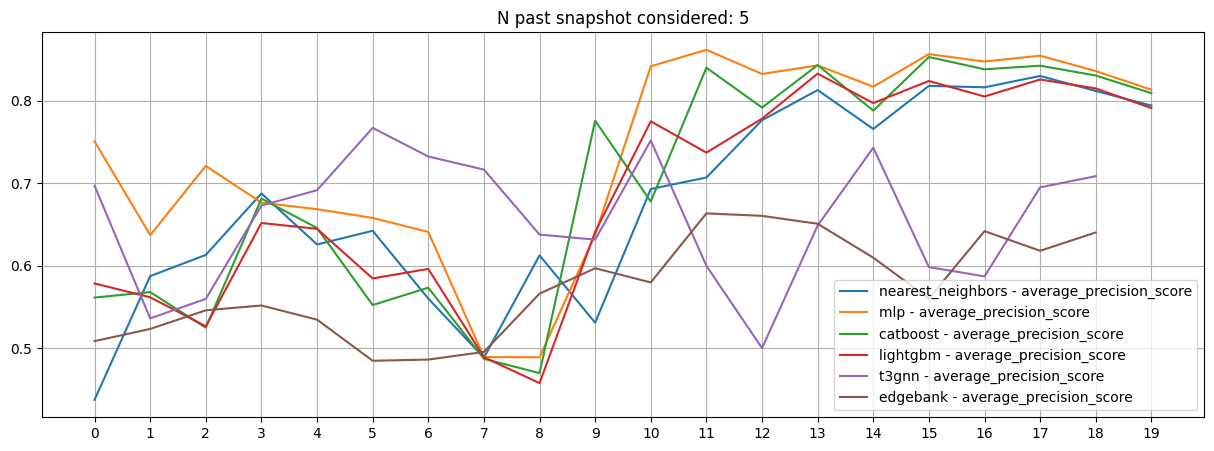

In [34]:
import pandas as pd

model_names = ["nearest_neighbors", "mlp", "catboost", "lightgbm", "t3gnn"]
model_names.append("edgebank")
#model_names.append("t3gnn")
for n_past_snapshot_to_consider in range(1, 6):
    print("N past snapshot considered: ", n_past_snapshot_to_consider)
    score_list = []
    for model_name in model_names:
        metrics_df = pd.read_csv(f"live_update_metrics/{n_past_snapshot_to_consider}_past_snapshot/{model_name}_metrics_df.csv").drop("snapshot_time", axis=1)
        score_list.append((model_name, metrics_df))
    compare_score_across_models(score_list)
    plt.title(f"N past snapshot considered: {n_past_snapshot_to_consider}")
    plt.show()

In [7]:
metric_of_interest = "average_precision_score"

metric_of_interest_df = pd.DataFrame()
for n_past_snapshot_to_consider in range(1, 6):
    n_past_snapshot_df = pd.DataFrame()
    for model_name in model_names:
        metrics_df = pd.read_csv(f"live_update_metrics/{n_past_snapshot_to_consider}_past_snapshot/{model_name}_metrics_df.csv").drop("snapshot_time", axis=1)
        n_past_snapshot_df[model_name] = metrics_df[metric_of_interest]
    metric_of_interest_df[f"{n_past_snapshot_to_consider}_past_snapshot - {metric_of_interest}"] = n_past_snapshot_df.mean()

metric_of_interest_df.T
    

,nearest_neighbors,mlp,catboost,lightgbm,edgebank
1_past_snapshot - average_precision_score,0.482482,0.726179,0.714898,0.706004,0.536946
2_past_snapshot - average_precision_score,0.706697,0.733432,0.719982,0.693158,0.544183
3_past_snapshot - average_precision_score,0.693399,0.712351,0.717873,0.705635,0.551894
4_past_snapshot - average_precision_score,0.689569,0.724277,0.713085,0.695018,0.563123
5_past_snapshot - average_precision_score,0.680710,0.738802,0.697854,0.685806,0.574764


In [17]:
pd.read_csv(f"live_update_metrics/{n_past_snapshot_to_consider}_past_snapshot/{model_name}_metrics_df.csv").drop("snapshot_time", axis=1).mean()

accuracy_score             0.596936
precision_score            0.618060
recall_score               0.428022
f1_score                   0.466952
roc_auc_score              0.597114
average_precision_score    0.574764
dtype: float64

In [35]:
model_names.append("t3gnn")
def get_average_values(n_past_snapshot_to_consider):
    model_names = ["nearest_neighbors", "mlp", "catboost", "lightgbm", "t3gnn", "edgebank"]
    df = pd.DataFrame()
    for model_name in model_names:
        metrics_df = pd.read_csv(f"live_update_metrics/{n_past_snapshot_to_consider}_past_snapshot/{model_name}_metrics_df.csv").drop("snapshot_time", axis=1).mean()
        df[model_name] = metrics_df
    return df

In [46]:
print(get_average_values(4).to_latex()\
      .replace("accuracy_score", "Accuracy")\
        .replace("precision_score", "Precision")\
            .replace("recall_score", "Recall")\
                .replace("f1_score", "F1")\
                    .replace("roc_auc_score", "ROC AUC")\
                        .replace("average_Precision", "Average Precision"))
get_average_values(1)

\begin{tabular}{lrrrrrr}
\toprule
 & nearest_neighbors & mlp & catboost & lightgbm & t3gnn & edgebank \\
\midrule
Accuracy & 0.717511 & 0.756197 & 0.742013 & 0.720312 & 0.622913 & 0.581944 \\
Precision & 0.747435 & 0.747547 & 0.760293 & 0.751795 & 0.717114 & 0.596679 \\
Recall & 0.671587 & 0.740099 & 0.676775 & 0.624847 & 0.605293 & 0.415850 \\
F1 & 0.698351 & 0.738762 & 0.710553 & 0.676130 & 0.643367 & 0.451037 \\
ROC AUC & 0.718119 & 0.756515 & 0.742426 & 0.720900 & 0.618220 & 0.582054 \\
Average Precision & 0.689569 & 0.724277 & 0.713085 & 0.695018 & 0.661735 & 0.563123 \\
\bottomrule
\end{tabular}



,nearest_neighbors,mlp,catboost,lightgbm,t3gnn,edgebank
accuracy_score,0.457224,0.760177,0.732347,0.722305,0.598740,0.543190
precision_score,0.477582,0.795260,0.767885,0.767943,0.704121,0.539940
recall_score,0.889095,0.717034,0.679304,0.658241,0.527253,0.398847
f1_score,0.621084,0.734523,0.709800,0.696002,0.586991,0.425215
roc_auc_score,0.454993,0.760697,0.732911,0.722975,0.601857,0.543020
average_precision_score,0.482482,0.726179,0.714898,0.706004,0.640999,0.536946
